# Визуализация промежуточных активаций

Визуализация промежуточных активаций заключается в отображении карт признаков, которые выводятся разными сверточными и объединяющими слоями в сети в ответ на определенные входные данные (вывод слоя, результат функции активации, часто называют его активацией). Этот прием позволяет увидеть, как входные данные разлагаются на различные фильтры, полученные сетью в процессе обучения. Обычно для визуализации используются карты признаков с тремя измерениями: шириной, высотой и глубиной (каналы цвета). Каналы кодируют относительно независимые признаки, поэтому для визуализации этих карт признаков предпочтительнее строить двумерные изображения для каждого канала в отдельности.

In [2]:
from tensorflow.keras.models import load_model
model = load_model('cats_and_dogs_small_1.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [4]:
img_path = 'C:/Users/Vladuk/1_books_ML/1_Tensorflow_Keras/cats_and_dogs_small/test/cats/cat.1000.jpg'
from tensorflow.keras.preprocessing import image 
import numpy as np
img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255. # Его форма (1, 150, 150, 3)
print(img_tensor.shape)

(1, 150, 150, 3)


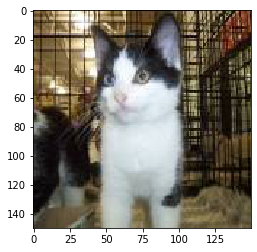

In [5]:
import matplotlib.pyplot as plt
plt.imshow(img_tensor[0])
plt.show()

Для извлечения карт признаков, подлежащих визуализации, создадим модель Keras, которая принимает пакеты изображений и выводит активации всех сверточных и объединяющих слоев. Для этого используем класс Model из фреймворка Keras. Конструктор модели принимает два аргумента: входной тензор (или список входных тензоров) и выходной тензор (или список выходных тензоров). В результате будет получен объект модели Keras, похожей на модели Sequential; эта модель отображает заданные входные данные в заданные выходные данные. Отличительной чертой класса Model является возможность создания моделей с несколькими выходами.

In [7]:
from tensorflow.keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
#Если передать этой модели изображение, она вернет значения активации слоев в исходной модели.  Вообще модель может иметь сколько угодно входов и выходов. 
#Данная модель имеет один вход и восемь выходов: по одному на каждую активацию слоя.

In [8]:
activations = activation_model.predict(img_tensor)

In [26]:
# Возьмем для примера активацию первого сверточного слоя для входного изображения кошки:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(1, 74, 74, 32)


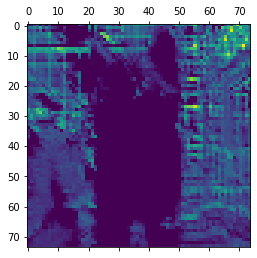

In [28]:
import matplotlib.pyplot as plt
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

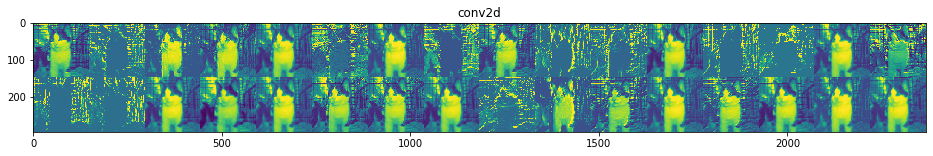

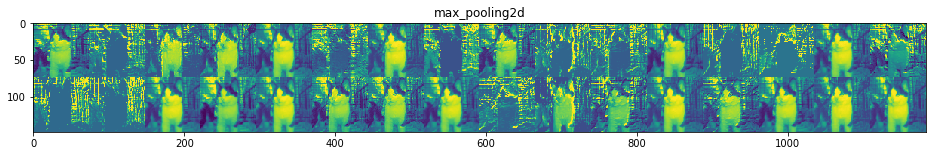

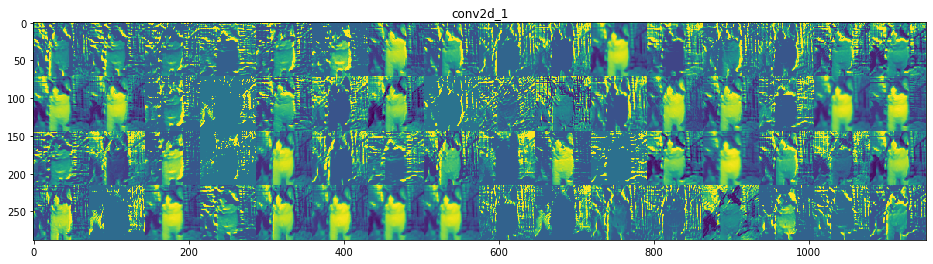

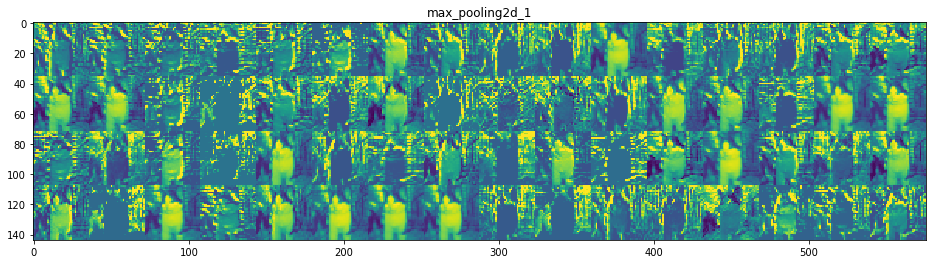

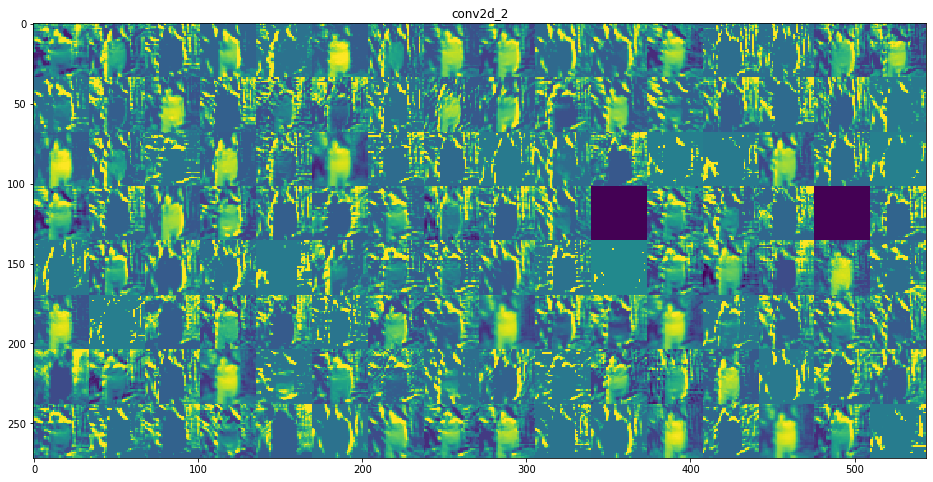

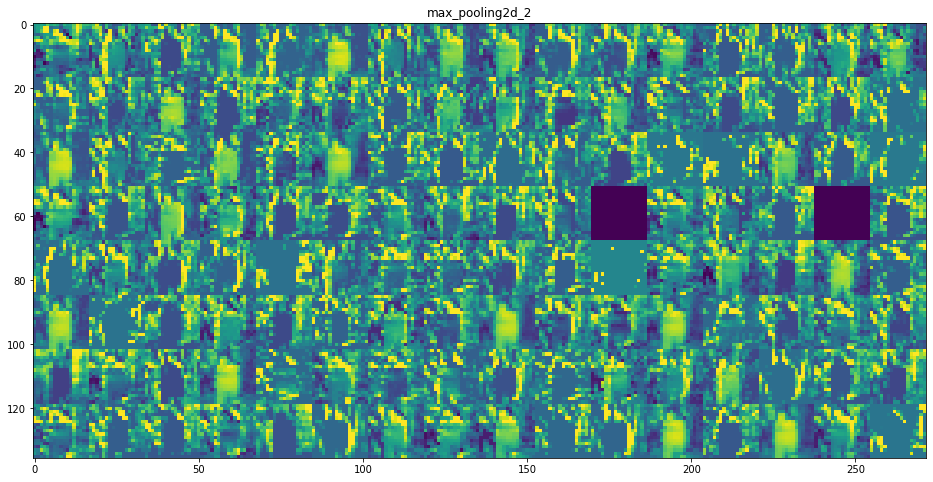

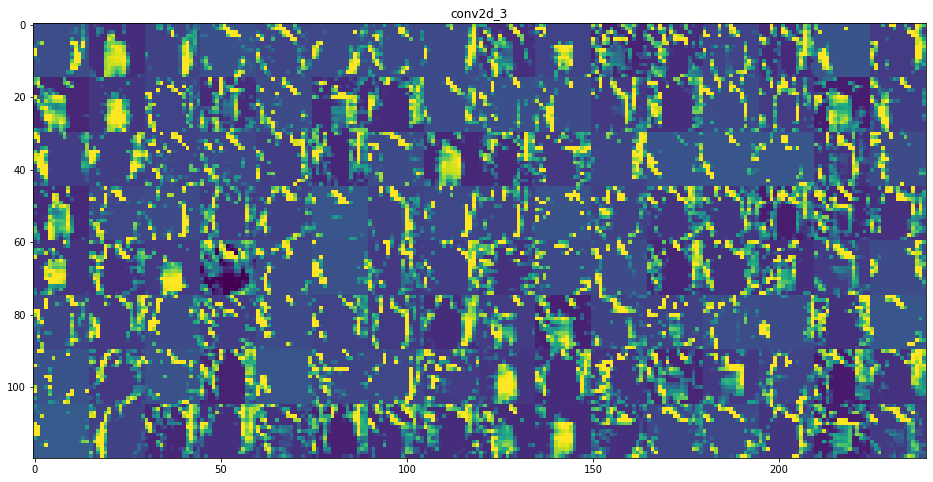

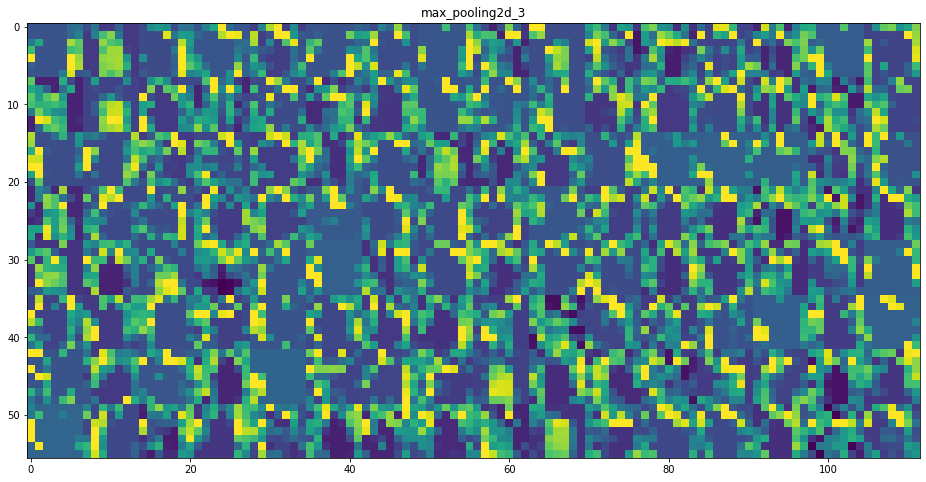

In [32]:
layer_names = []
for layer in model.layers[:8]: 
    layer_names.append(layer.name) #извлечение имен слоев
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): 
    n_features = layer_activation.shape[-1] #колличество признаков в карте признаков
    size = layer_activation.shape[1] 
    n_cols = n_features // images_per_row #колличество колонок в карте отображения признаков
    display_grid = np.zeros((size * n_cols, images_per_row * size)) 
    for col in range(n_cols): #вывод каждого фильтра в большую горизонтальную сетку
        for row in range(images_per_row): 
            channel_image = layer_activation[0, :, :, col * images_per_row + row] 
            channel_image -= channel_image.mean() #обработка признака
            channel_image /= channel_image.std() 
            channel_image *= 64 
            channel_image += 128 
            channel_image = np.clip(channel_image, 0, 255).astype('uint8') 
            display_grid[col * size : (col + 1) * size,  row * size : (row + 1) * size] = channel_image #вывод сетки
    scale = 1. / size 
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0])) 
    plt.title(layer_name)
    plt.grid(False) 
    plt.imshow(display_grid, aspect='auto', cmap='viridis')